In [90]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
from sklearn.metrics.pairwise import nan_euclidean_distances
from sklearn.metrics import pairwise_distances, pairwise_distances_chunked
from tqdm import tqdm

sc.settings.verbosity = 4
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()
sc.set_figure_params(frameon=False, color_map='magma_r')

import splicing_utils


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
scanpy==1.4.6.dev9+ge632939 anndata==0.7rc1 umap==0.3.10 numpy==1.17.3 scipy==1.3.2 pandas==0.25.3 scikit-learn==0.22 statsmodels==0.10.2 python-igraph==0.7.1 louvain==0.6.1


## Data folder

In [57]:
splicing_folder = '/home/olga/data_sm/splicing/rawdata/rijk_zscore__2020-10-13'
! ls -lha $splicing_folder

total 30G
drwxr-xr-x 4 olga czb 4.0K Sep 21 10:08 .
drwxr-xr-x 5 olga czb 4.0K Sep 23 07:41 ..
drwxr-xr-x 2 olga czb 4.0K Sep 21 10:09 concatenated
-rw-r--r-- 1 olga czb 829M Sep 15 11:29 COVID_pilot2_sym_S_0.1_z_0.0_b_5.pq
-rw-r--r-- 1 olga czb 3.5G Sep 15 11:30 COVID_pilot3_sym_S_0.1_z_0.0_b_5.pq
-rw-r--r-- 1 olga czb 3.0G Sep 15 11:37 lemur_Antoine_4_sym_S_0.1_z_0.0_b_5.pq
-rw-r--r-- 1 olga czb 316M Sep 15 11:37 lemur_Bernard_4_sym_S_0.1_z_0.0_b_5.pq
-rw-r--r-- 1 olga czb 333M Sep 15 11:37 lemur_Martine_4_sym_S_0.1_z_0.0_b_5.pq
-rw-r--r-- 1 olga czb 1.6G Sep 15 11:38 lemur_Stumpy_4_sym_S_0.1_z_0.0_b_5.pq
drwxr-xr-x 2 olga czb 4.0K Sep 21 08:02 nan_aware_distances
-rw-r--r-- 1 olga czb 1.8G Sep 15 11:36 TS_10x_redo_sym_S_0.1_z_0.0_b_5.pq
-rw-r--r-- 1 olga czb 3.1G Sep 15 11:31 TSP1_SS2_sym_S_0.1_z_0.0_b_5.pq
-rw-r--r-- 1 olga czb 5.5G Sep 15 11:33 TSP2_10x_rerun_3prime_sym_S_0.1_z_0.0_b_5.pq
-rw-r--r-- 1 olga czb  11G Sep 15 11:35 TSP2_SS2_sym_S_0.1_z_0.0_b_5.pq


# Read in concatenated Tabula Sapiens data

In [58]:
splicing2d = pd.read_parquet(f'{splicing_folder}/concatenated/tabula_sapiens_splicing_2d.parquet')
print(splicing2d.shape)
splicing2d.head()

(122272, 3873)


geneR1A_uniq,A2M,AAAS,AAK1,AAMDC,AARSD1,AASDH,ABCA10,ABCA6,ABCA8,ABCA9,...,ZNHIT1,ZNRF1,ZRANB2,ZRSR2,ZSWIM7,bP-2189O9.2,pRNA,snoU13,uc_338,unknown
cell_id,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGAAGTCAT_TSP2_LymphNode_NA_10X_2_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCCAAGAGGGTGG_TSP2_SI_proximal_10X_1_1_Duodenum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCCAAGATGTTAG_TSP1_muscle_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCCAAGATTGACA_TSP1_lung_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCCAAGCAACAGC_TSP1_blood_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.309925,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
genes_with_splicing = splicing2d.notnull().sum()
print(genes_with_splicing.shape)

(3873,)


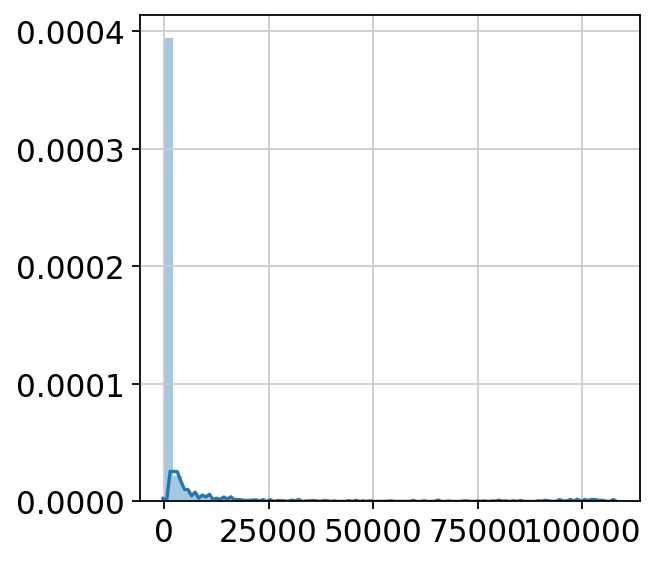

In [63]:
sns.distplot(genes_with_splicing)

In [74]:
genes_with_splicing[genes_with_splicing > 1000]

geneR1A_uniq
A2M            6275
AAMDC          1015
ABI3BP         1462
AC005329.7     1313
AC019349.5     1507
              ...  
ZC3H15         2376
ZFAND5         1423
ZFAS1         34627
ZNHIT1         1242
unknown        1845
Length: 801, dtype: int64

In [77]:
genes_with_splicing['MYL6']

71618

In [78]:
genes_with_splicing['RPS24']

79780

In [79]:
genes_with_splicing['PKM']

8

In [80]:
genes_with_splicing['MYL4']

223

In [84]:
genes_with_splicing['MAP4K4']

11

In [86]:
genes_with_splicing['SNAP23']

18

In [81]:
(genes_with_splicing >= 5).sum()

3109

In [88]:
splicing2d_min_cells_per_gene =splicing2d.loc[:, genes_with_splicing >= 10]
splicing2d_min_cells_per_gene.shape

(122272, 2781)

## Compute splicing distances

In [1]:
# %%time

# tsp1_tsp2_10x_dists = splicing_utils.compute_distances_df(splicing2d_min_cells_per_gene, n_jobs=96)
# print(tsp1_tsp2_10x_dists.shape)
# tsp1_tsp2_10x_dists.head()

In [2]:
distances_folder = f'{splicing_folder}/nan_aware_distances'

NameError: name 'splicing_folder' is not defined

# Read in splicing distances data

In [6]:
parquet = f"{distances_folder}/TS_10x_redo_sym_S_0.1_z_0.0_b_5__distances.parquet"
splicing_dists = pd.read_parquet(parquet)
print(splicing_dists.shape)
splicing_dists.head()

(32042, 32042)


cell,TSP1_bladder_1_S7_L00_AAACCCATCCTTCGAC,TSP1_bladder_1_S7_L00_AAACCCATCGAAGGAC,TSP1_bladder_1_S7_L00_AAACGAAGTGAGTAAT,TSP1_bladder_1_S7_L00_AAACGCTAGCACGGAT,TSP1_bladder_1_S7_L00_AAACGCTGTACCGGCT,TSP1_bladder_1_S7_L00_AAACGCTGTCATCGCG,TSP1_bladder_1_S7_L00_AAACGCTGTCCAAGAG,TSP1_bladder_1_S7_L00_AAACGCTTCTGTGCGG,TSP1_bladder_1_S7_L00_AAAGAACAGCAATTAG,TSP1_bladder_1_S7_L00_AAAGAACCAAGTTCCA,...,TSP1_muscle_3_S15_L00_TTTCCTCAGGCCTTCG,TSP1_muscle_3_S15_L00_TTTCCTCGTGAAGCGT,TSP1_muscle_3_S15_L00_TTTCGATAGGTTAAAC,TSP1_muscle_3_S15_L00_TTTCGATCAAGCTGTT,TSP1_muscle_3_S15_L00_TTTGACTAGGGTGAAA,TSP1_muscle_3_S15_L00_TTTGACTCACTGCGAC,TSP1_muscle_3_S15_L00_TTTGGTTCATTGCCGG,TSP1_muscle_3_S15_L00_TTTGGTTTCGGCTTCT,TSP1_muscle_3_S15_L00_TTTGTTGCAACGCATT,TSP1_muscle_3_S15_L00_TTTGTTGGTAACATAG
cell,,,,,,,,,,,,,,,,,,,,,
TSP1_bladder_1_S7_L00_AAACCCATCCTTCGAC,0.000000,59.681675,54.006681,78.348585,82.678733,75.128480,76.926503,88.280793,65.164759,86.866832,...,78.977566,105.171392,115.530661,111.955806,96.520607,102.274700,119.091830,83.312637,109.818735,93.084221
TSP1_bladder_1_S7_L00_AAACCCATCGAAGGAC,59.681675,0.000000,59.345095,76.225425,78.737491,75.755162,75.832254,94.994400,64.339622,85.339229,...,81.055964,99.155290,97.082288,103.114181,96.520489,91.545132,108.473600,76.814927,100.223919,97.281255
TSP1_bladder_1_S7_L00_AAACGAAGTGAGTAAT,54.006681,59.345095,0.000000,78.878612,77.245525,80.905339,75.815077,92.361255,70.248862,82.053080,...,74.822013,91.717457,103.667761,105.545372,91.477729,86.763019,93.912776,68.609522,82.904133,91.627158
TSP1_bladder_1_S7_L00_AAACGCTAGCACGGAT,78.348585,76.225425,78.878612,0.000000,76.557185,81.551780,85.902326,101.582217,70.064612,75.030835,...,112.167574,115.575160,111.155076,133.215103,115.674800,114.514531,123.089299,106.459560,116.008436,105.043798
TSP1_bladder_1_S7_L00_AAACGCTGTACCGGCT,82.678733,78.737491,77.245525,76.557185,0.000000,92.795427,83.010425,99.219235,81.767535,71.746291,...,111.531228,118.367638,110.765373,138.208647,122.212057,113.336860,118.050257,111.109617,119.223472,106.735774


## Fix cell ids

In [8]:
matches = splicing_dists.index.str.extractall('(?P<channel_cleaned>[\w-]+)_S\d+_L\d+_(?P<cell_barcode>[ACGT]+)')
matches = matches.droplevel(-1)
cell_ids = matches['cell_barcode'].astype(str) + '_' + matches['channel_cleaned'].astype(str)
cell_ids

0        AAACCCATCCTTCGAC_TSP1_bladder_1
1        AAACCCATCGAAGGAC_TSP1_bladder_1
2        AAACGAAGTGAGTAAT_TSP1_bladder_1
3        AAACGCTAGCACGGAT_TSP1_bladder_1
4        AAACGCTGTACCGGCT_TSP1_bladder_1
                      ...               
32037     TTTGACTCACTGCGAC_TSP1_muscle_3
32038     TTTGGTTCATTGCCGG_TSP1_muscle_3
32039     TTTGGTTTCGGCTTCT_TSP1_muscle_3
32040     TTTGTTGCAACGCATT_TSP1_muscle_3
32041     TTTGTTGGTAACATAG_TSP1_muscle_3
Length: 32042, dtype: object

In [29]:
splicing_dists_fixed_ids = splicing_dists.copy()
splicing_dists_fixed_ids.index = cell_ids.values
splicing_dists_fixed_ids.columns = cell_ids.values
splicing_dists_fixed_ids.head()

,AAACCCATCCTTCGAC_TSP1_bladder_1,AAACCCATCGAAGGAC_TSP1_bladder_1,AAACGAAGTGAGTAAT_TSP1_bladder_1,AAACGCTAGCACGGAT_TSP1_bladder_1,AAACGCTGTACCGGCT_TSP1_bladder_1,AAACGCTGTCATCGCG_TSP1_bladder_1,AAACGCTGTCCAAGAG_TSP1_bladder_1,AAACGCTTCTGTGCGG_TSP1_bladder_1,AAAGAACAGCAATTAG_TSP1_bladder_1,AAAGAACCAAGTTCCA_TSP1_bladder_1,...,TTTCCTCAGGCCTTCG_TSP1_muscle_3,TTTCCTCGTGAAGCGT_TSP1_muscle_3,TTTCGATAGGTTAAAC_TSP1_muscle_3,TTTCGATCAAGCTGTT_TSP1_muscle_3,TTTGACTAGGGTGAAA_TSP1_muscle_3,TTTGACTCACTGCGAC_TSP1_muscle_3,TTTGGTTCATTGCCGG_TSP1_muscle_3,TTTGGTTTCGGCTTCT_TSP1_muscle_3,TTTGTTGCAACGCATT_TSP1_muscle_3,TTTGTTGGTAACATAG_TSP1_muscle_3
AAACCCATCCTTCGAC_TSP1_bladder_1,0.000000,59.681675,54.006681,78.348585,82.678733,75.128480,76.926503,88.280793,65.164759,86.866832,...,78.977566,105.171392,115.530661,111.955806,96.520607,102.274700,119.091830,83.312637,109.818735,93.084221
AAACCCATCGAAGGAC_TSP1_bladder_1,59.681675,0.000000,59.345095,76.225425,78.737491,75.755162,75.832254,94.994400,64.339622,85.339229,...,81.055964,99.155290,97.082288,103.114181,96.520489,91.545132,108.473600,76.814927,100.223919,97.281255
AAACGAAGTGAGTAAT_TSP1_bladder_1,54.006681,59.345095,0.000000,78.878612,77.245525,80.905339,75.815077,92.361255,70.248862,82.053080,...,74.822013,91.717457,103.667761,105.545372,91.477729,86.763019,93.912776,68.609522,82.904133,91.627158
AAACGCTAGCACGGAT_TSP1_bladder_1,78.348585,76.225425,78.878612,0.000000,76.557185,81.551780,85.902326,101.582217,70.064612,75.030835,...,112.167574,115.575160,111.155076,133.215103,115.674800,114.514531,123.089299,106.459560,116.008436,105.043798
AAACGCTGTACCGGCT_TSP1_bladder_1,82.678733,78.737491,77.245525,76.557185,0.000000,92.795427,83.010425,99.219235,81.767535,71.746291,...,111.531228,118.367638,110.765373,138.208647,122.212057,113.336860,118.050257,111.109617,119.223472,106.735774


# Read h5ad

In [11]:
h5ad = '/home/olga/Pilot1_Pilot2_filtered_ensembl_id_Aug5.ss2_norm.ann.compartment.allgenes.h5ad'
adata = sc.read(h5ad)
adata

Only considering the two last: ['.allgenes', '.h5ad'].
Only considering the two last: ['.allgenes', '.h5ad'].


AnnData object with n_obs × n_vars = 207016 × 58870 
    obs: '10X_run', 'smartseq2_barcode', 'smartseq2_library_plate', 'smartseq2_sorting_direction', 'smartseq2_sort_order', 'smartseq2_cDNA_Plate', 'cell_id', 'method', 'donor', '10X_replicate', 'sequencer', 'sex', 'tissue', 'smartseq2_well_seq', 'notes', 'smartseq2_sorted_population', '10X_sample', 'anatomical_position', '10X_barcode', 'n_counts', 'n_genes', 'manual_cell_ontology_class', 'manual_annotation', 'doublet_filter', 'compartment', 'batch', 'compartment_pred', 'leiden', 'cluster_id', 'Propagated Annotation', 'Entropy All Methods', 'Entropy kNN Reps', 'Entropy scANVI Reps', 'Entropy SVM Reps', 'Potential Doublets', 'Onclass', 'singlecellNet', 'kNN', 'SVM', 'scANVI', 'compartment_pred_svm', 'manual_cell_ontology_classcollapsed', 'Propagated Annotationcollapsed', 'Onclasscollapsed', 'singlecellNetcollapsed', 'kNNcollapsed', 'SVMcollapsed', 'scANVIcollapsed', 'miscompartmentalized', 'log_n_counts', 'log_n_genes'
    var: 'featur

## Filter adata for only cells with splicing data

In [14]:
cells_with_splicing_data = splicing_dists_fixed_ids.index.intersection(adata.obs.index)
len(cells_with_splicing_data)

31118

In [15]:
adata_has_splicing_data = adata[cells_with_splicing_data ]
adata_has_splicing_data

View of AnnData object with n_obs × n_vars = 31118 × 58870 
    obs: '10X_run', 'smartseq2_barcode', 'smartseq2_library_plate', 'smartseq2_sorting_direction', 'smartseq2_sort_order', 'smartseq2_cDNA_Plate', 'cell_id', 'method', 'donor', '10X_replicate', 'sequencer', 'sex', 'tissue', 'smartseq2_well_seq', 'notes', 'smartseq2_sorted_population', '10X_sample', 'anatomical_position', '10X_barcode', 'n_counts', 'n_genes', 'manual_cell_ontology_class', 'manual_annotation', 'doublet_filter', 'compartment', 'batch', 'compartment_pred', 'leiden', 'cluster_id', 'Propagated Annotation', 'Entropy All Methods', 'Entropy kNN Reps', 'Entropy scANVI Reps', 'Entropy SVM Reps', 'Potential Doublets', 'Onclass', 'singlecellNet', 'kNN', 'SVM', 'scANVI', 'compartment_pred_svm', 'manual_cell_ontology_classcollapsed', 'Propagated Annotationcollapsed', 'Onclasscollapsed', 'singlecellNetcollapsed', 'kNNcollapsed', 'SVMcollapsed', 'scANVIcollapsed', 'miscompartmentalized', 'log_n_counts', 'log_n_genes'
    var: 

In [41]:
for col in adata_has_splicing_data.obs:
    print(f'\n- {col} -')
    print(adata_has_splicing_data.obs[col].value_counts().head(10))


- 10X_run -
TSP1_lung_3            5048
TSP1_lung_2            4100
TSP1_bladder_1         3297
TSP1_bladder_2         3041
TSP1_bladder_3         3017
TSP1_lung_1            2565
TSP1_blood_3           1292
TSP1_blood_1           1196
TSP1_blood_2           1176
TSP1_exopancreas2_3    1078
Name: 10X_run, dtype: int64

- smartseq2_barcode -
nan    31118
Name: smartseq2_barcode, dtype: int64

- smartseq2_library_plate -
nan    31118
Name: smartseq2_library_plate, dtype: int64

- smartseq2_sorting_direction -
nan    31118
Name: smartseq2_sorting_direction, dtype: int64

- smartseq2_sort_order -
nan    28156
2       2878
1         84
Name: smartseq2_sort_order, dtype: int64

- smartseq2_cDNA_Plate -
nan    31118
Name: smartseq2_cDNA_Plate, dtype: int64

- cell_id -
GACCCAGCAAACAGGC_TSP1_bladder_2    1
ATCCATTTCCCTAGGG_TSP1_lung_2       1
CTAGACAAGATAACAC_TSP1_lung_1       1
CATCAAGTCTACGGGC_TSP1_bladder_1    1
AGACACTGTGAATGTA_TSP1_bladder_3    1
AAGCGAGGTTGCTTGA_TSP1_lung_3       1
TTAT

## Filter splicing distances for only cells in adata

In [30]:
splicing_dists_fixed_ids_with_adata = splicing_dists_fixed_ids.loc[cells_with_splicing_data, cells_with_splicing_data]
print(splicing_dists_fixed_ids_with_adata.shape)
splicing_dists_fixed_ids_with_adata.head()

(31118, 31118)


,AAACCCATCCTTCGAC_TSP1_bladder_1,AAACCCATCGAAGGAC_TSP1_bladder_1,AAACGAAGTGAGTAAT_TSP1_bladder_1,AAACGCTAGCACGGAT_TSP1_bladder_1,AAACGCTGTACCGGCT_TSP1_bladder_1,AAACGCTGTCATCGCG_TSP1_bladder_1,AAACGCTGTCCAAGAG_TSP1_bladder_1,AAACGCTTCTGTGCGG_TSP1_bladder_1,AAAGAACAGCAATTAG_TSP1_bladder_1,AAAGAACCAAGTTCCA_TSP1_bladder_1,...,TTTCCTCAGCCTGACC_TSP1_muscle_3,TTTCCTCAGGCCTTCG_TSP1_muscle_3,TTTCCTCGTGAAGCGT_TSP1_muscle_3,TTTCGATAGGTTAAAC_TSP1_muscle_3,TTTCGATCAAGCTGTT_TSP1_muscle_3,TTTGACTAGGGTGAAA_TSP1_muscle_3,TTTGACTCACTGCGAC_TSP1_muscle_3,TTTGGTTCATTGCCGG_TSP1_muscle_3,TTTGGTTTCGGCTTCT_TSP1_muscle_3,TTTGTTGCAACGCATT_TSP1_muscle_3
AAACCCATCCTTCGAC_TSP1_bladder_1,0.000000,59.681675,54.006681,78.348585,82.678733,75.128480,76.926503,88.280793,65.164759,86.866832,...,107.415576,78.977566,105.171392,115.530661,111.955806,96.520607,102.274700,119.091830,83.312637,109.818735
AAACCCATCGAAGGAC_TSP1_bladder_1,59.681675,0.000000,59.345095,76.225425,78.737491,75.755162,75.832254,94.994400,64.339622,85.339229,...,90.933443,81.055964,99.155290,97.082288,103.114181,96.520489,91.545132,108.473600,76.814927,100.223919
AAACGAAGTGAGTAAT_TSP1_bladder_1,54.006681,59.345095,0.000000,78.878612,77.245525,80.905339,75.815077,92.361255,70.248862,82.053080,...,92.927412,74.822013,91.717457,103.667761,105.545372,91.477729,86.763019,93.912776,68.609522,82.904133
AAACGCTAGCACGGAT_TSP1_bladder_1,78.348585,76.225425,78.878612,0.000000,76.557185,81.551780,85.902326,101.582217,70.064612,75.030835,...,105.760825,112.167574,115.575160,111.155076,133.215103,115.674800,114.514531,123.089299,106.459560,116.008436
AAACGCTGTACCGGCT_TSP1_bladder_1,82.678733,78.737491,77.245525,76.557185,0.000000,92.795427,83.010425,99.219235,81.767535,71.746291,...,99.657117,111.531228,118.367638,110.765373,138.208647,122.212057,113.336860,118.050257,111.109617,119.223472


# Do UMAP

In [16]:
import bbknn

In [31]:
umapper = umap.UMAP(metric='precomputed', verbose=True)
umapped = umapper.fit_transform(splicing_dists_fixed_ids_with_adata)
umapped

/home/olga/miniconda3/envs/tabula-microcebus-v2/lib/python3.7/site-packages/umap/umap_.py:1461: UserWarning: Using precomputed metric; transform will be unavailable for new data
  "Using precomputed metric; transform will be unavailable for new data"


array([[ 5.644592 , -4.9868565],
       [ 7.496217 , -2.363556 ],
       [ 7.5955377, -3.8601859],
       ...,
       [ 4.4365034, -6.9621005],
       [ 4.8007975, -6.8123975],
       [ 4.1792173, -7.2604394]], dtype=float32)

In [32]:
umapped.shape

(31118, 2)

In [33]:
adata_has_splicing_data.obsm['X_umap_splicing'] = umapped

## Plot UMAP

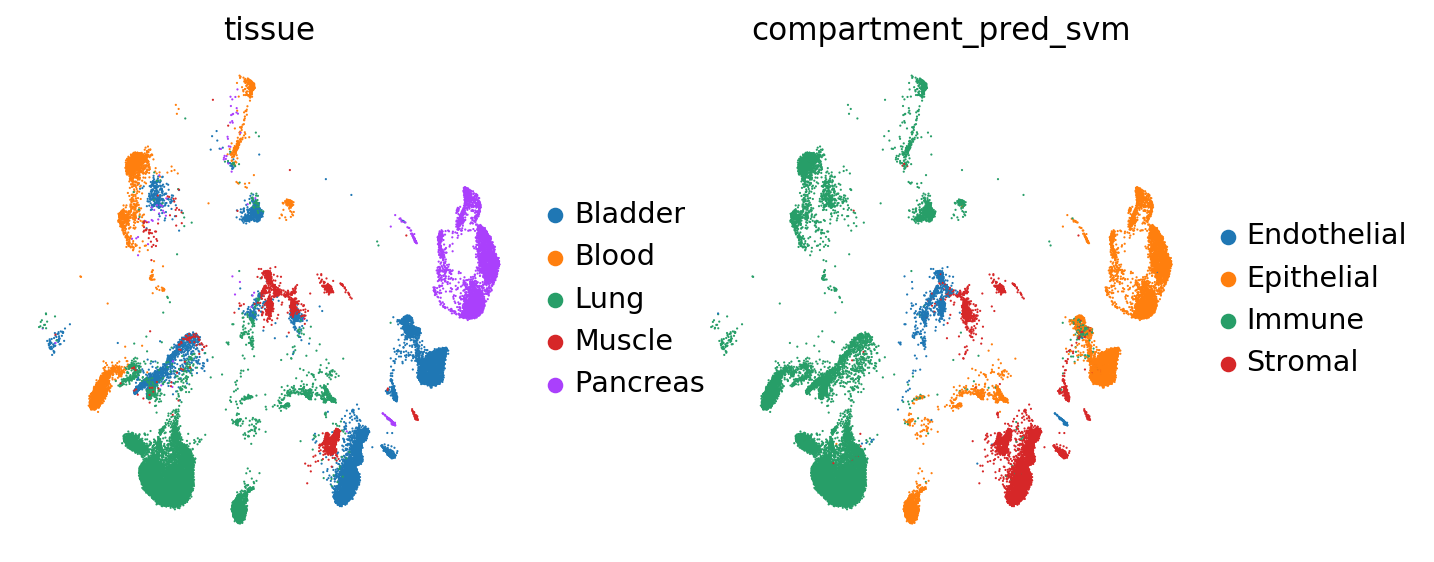

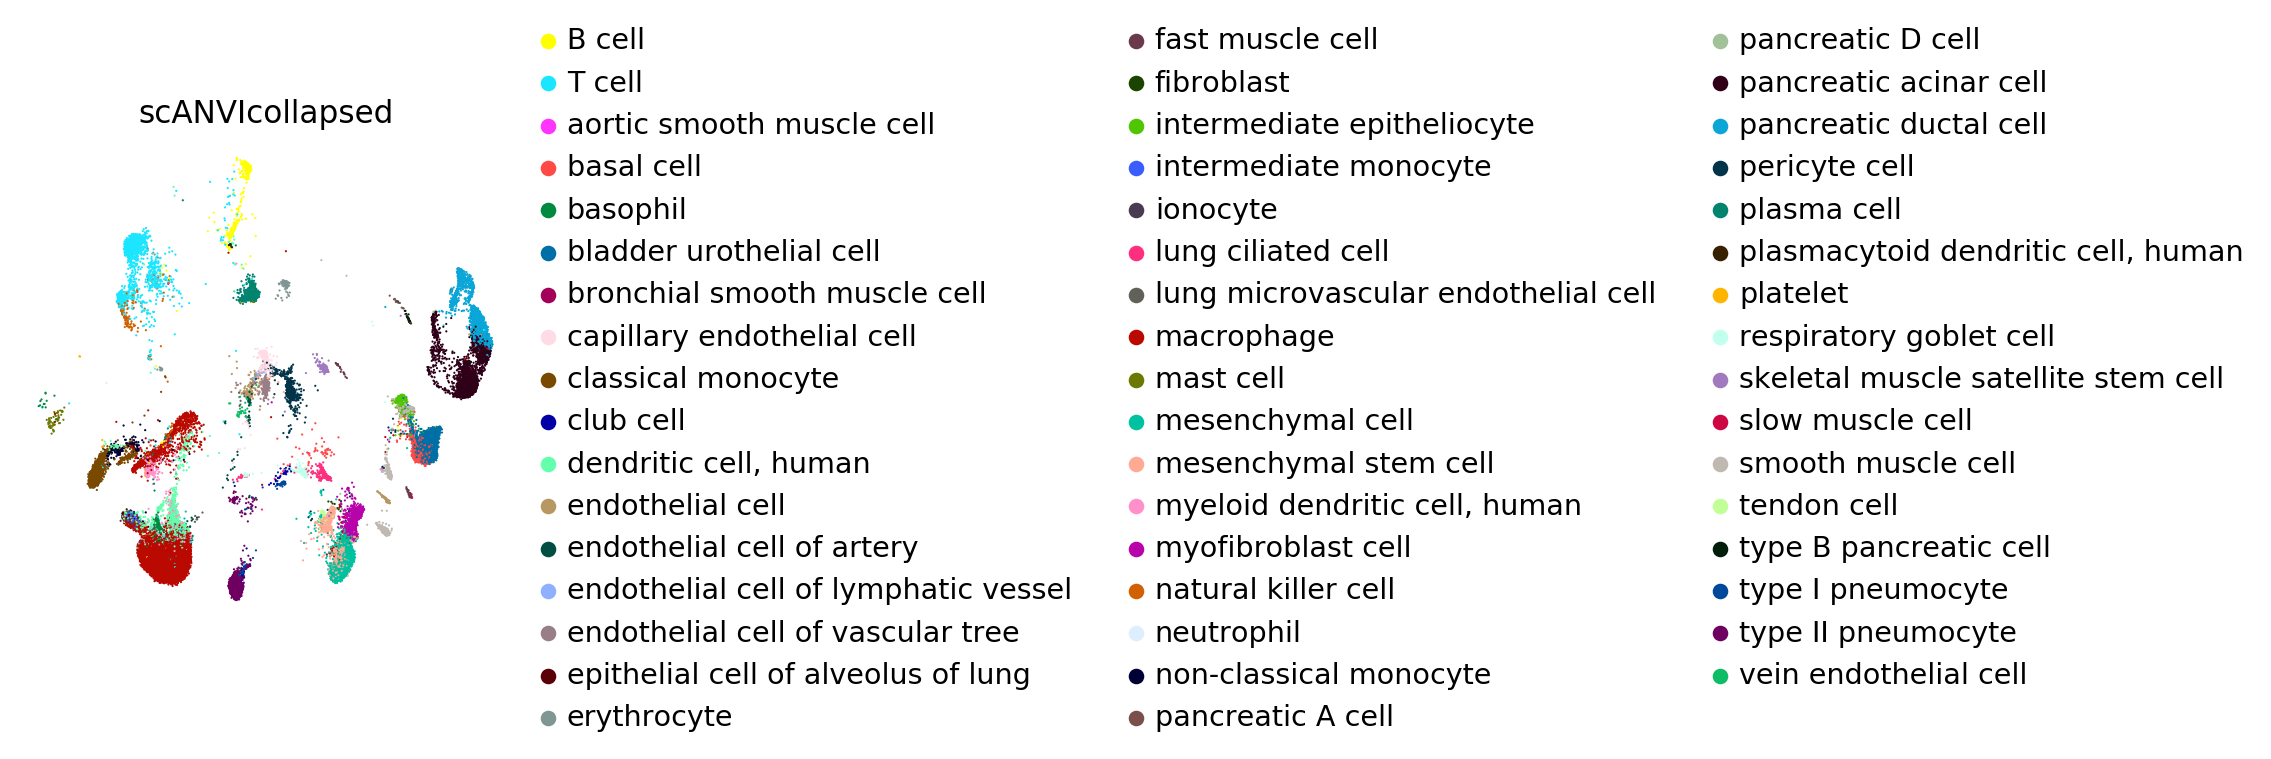

In [44]:
sc.pl.umap(adata_has_splicing_data, layer='X_umap_splicing', color=['tissue', 'compartment_pred_svm'])
sc.pl.umap(adata_has_splicing_data, layer='X_umap_splicing', color='scANVIcollapsed')

## Muscle only umap

In [45]:
adata_muscle = adata_has_splicing_data[adata_has_splicing_data.obs.tissue == "Muscle"]
adata_muscle

View of AnnData object with n_obs × n_vars = 2193 × 58870 
    obs: '10X_run', 'smartseq2_barcode', 'smartseq2_library_plate', 'smartseq2_sorting_direction', 'smartseq2_sort_order', 'smartseq2_cDNA_Plate', 'cell_id', 'method', 'donor', '10X_replicate', 'sequencer', 'sex', 'tissue', 'smartseq2_well_seq', 'notes', 'smartseq2_sorted_population', '10X_sample', 'anatomical_position', '10X_barcode', 'n_counts', 'n_genes', 'manual_cell_ontology_class', 'manual_annotation', 'doublet_filter', 'compartment', 'batch', 'compartment_pred', 'leiden', 'cluster_id', 'Propagated Annotation', 'Entropy All Methods', 'Entropy kNN Reps', 'Entropy scANVI Reps', 'Entropy SVM Reps', 'Potential Doublets', 'Onclass', 'singlecellNet', 'kNN', 'SVM', 'scANVI', 'compartment_pred_svm', 'manual_cell_ontology_classcollapsed', 'Propagated Annotationcollapsed', 'Onclasscollapsed', 'singlecellNetcollapsed', 'kNNcollapsed', 'SVMcollapsed', 'scANVIcollapsed', 'miscompartmentalized', 'log_n_counts', 'log_n_genes'
    var: '

In [48]:
splicing_dists_fixed_ids_with_adata_muscle = splicing_dists_fixed_ids_with_adata.loc[adata_muscle.obs.index, adata_muscle.obs.index]
print(splicing_dists_fixed_ids_with_adata_muscle.shape)

(2193, 2193)


In [50]:
umapper = umap.UMAP(metric='precomputed', verbose=True)
umapped_muscle = umapper.fit_transform(splicing_dists_fixed_ids_with_adata_muscle)
umapped_muscle 

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
     learning_rate=1.0, local_connectivity=1.0, metric='precomputed',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, random_state=None,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, verbose=True)
Construct fuzzy simplicial set
Mon Sep 21 09:51:51 2020 Finding Nearest Neighbors
Mon Sep 21 09:51:51 2020 Finished Nearest Neighbor Search
Mon Sep 21 09:51:51 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Sep 21

array([[-0.9457492 ,  3.9201145 ],
       [ 1.8391552 ,  3.135511  ],
       [ 0.32081354,  2.2166095 ],
       ...,
       [-1.9584141 ,  1.6855516 ],
       [-2.363297  ,  1.4350016 ],
       [-2.640851  ,  2.098865  ]], dtype=float32)

### Add splicing muslce umap

In [51]:
adata_muscle.obsm['X_umap_splicing'] = umapped_muscle

## Plot UMAP of muscle only

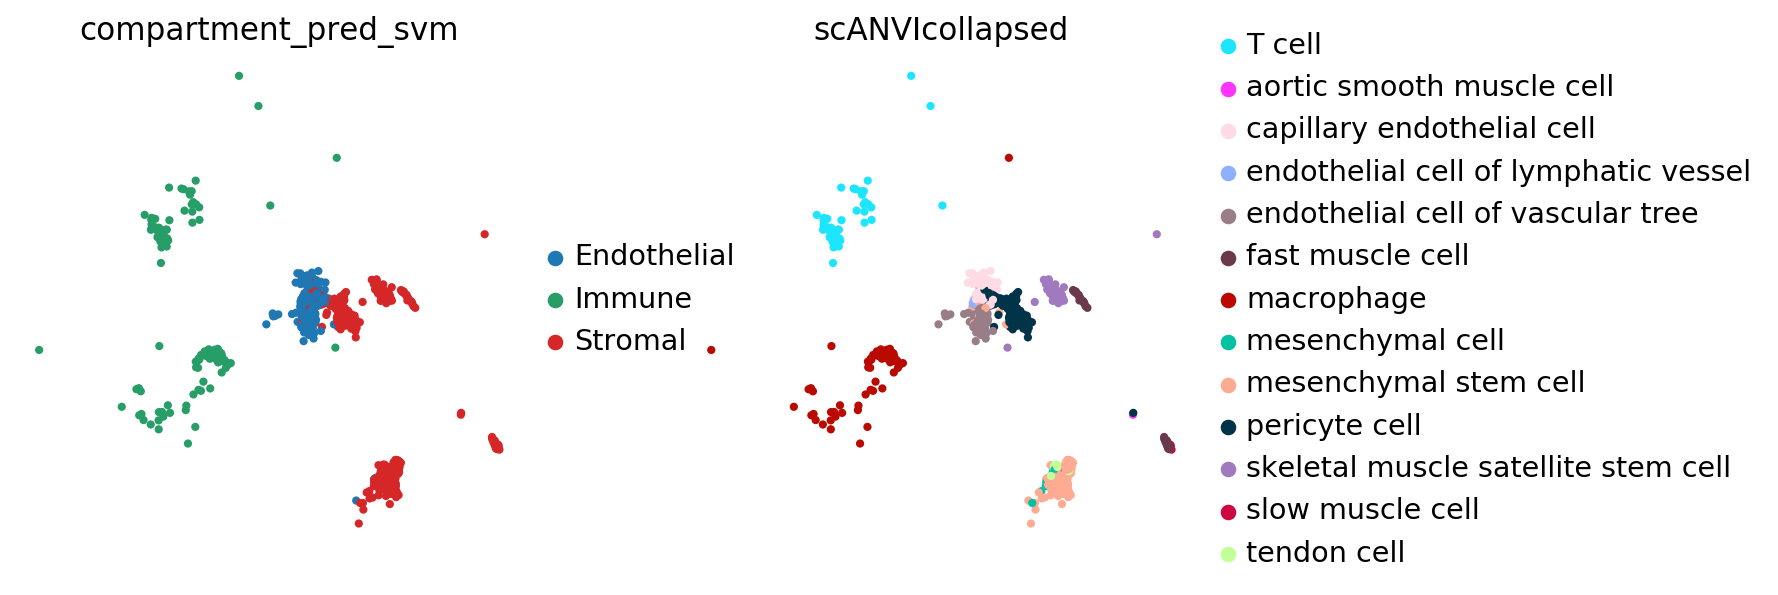

In [56]:
sc.pl.umap(adata_muscle, layer='X_umap_splicing', color=['compartment_pred_svm', 'scANVIcollapsed'])
# sc.pl.umap(adata_muscle, layer='X_umap_splicing', color='scANVIcollapsed')

In [16]:
adata.obsm['']

KeyError: ''

# Do BBKNN and UMAP

In [ ]:
import bbknn

In [ ]:
batch_keys = adata.obs.loc[muscle_df.index]

In [ ]:
bbknn.bbknn_pca_matrix(muscle_dists_df,  metric='precomputed')